# READING CHAMPIAGNE SALES DATA AND PERFORMING SOME PREPRCOESSING

In [90]:
import pandas as pd

df = pd.read_csv(r"C:\Users\seanr\Desktop\Projects\champaigne sales -time series\perrin-freres-monthly-champagne.csv")
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [91]:
df.rename(columns={"Perrin Freres monthly champagne sales millions ?64-?72":"Sales"},inplace=True)
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [92]:
print(df.describe())

              Sales
count    105.000000
mean    4761.152381
std     2553.502601
min     1413.000000
25%     3113.000000
50%     4217.000000
75%     5221.000000
max    13916.000000


In [93]:
df.dtypes

Month     object
Sales    float64
dtype: object

In [94]:
df.tail()

,Month,Sales
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [95]:
df.isnull().sum()

Month    1
Sales    2
dtype: int64

In [96]:
# As we can see we have some null values at the bottom of our dataset , lets get rid of them

df = df.dropna(axis=0, subset=['Sales'])


In [97]:
#We need to connvert month to datatime and set the index to month

df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


<Axes: xlabel='Month'>

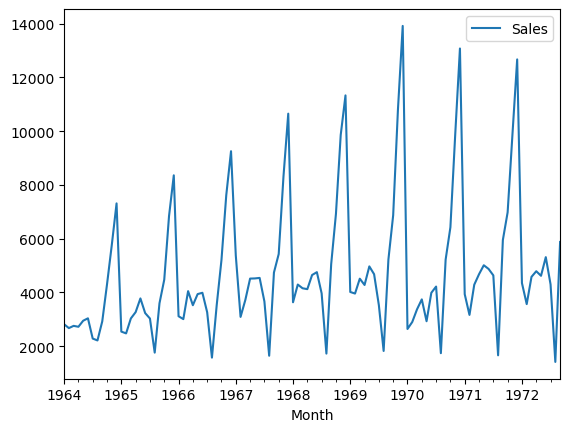

In [98]:
# As we can see from the plot we observe seasonailty and dataset is possibly not stationary

df.plot()

In [99]:
# FOR A TIME SERIES DATASET TO BE STATIONARY , IT NEEDS TO HAVE SOMEWHAT SIMILAR MEAN AND VARIANCE IN EACH TIME INTERVAL

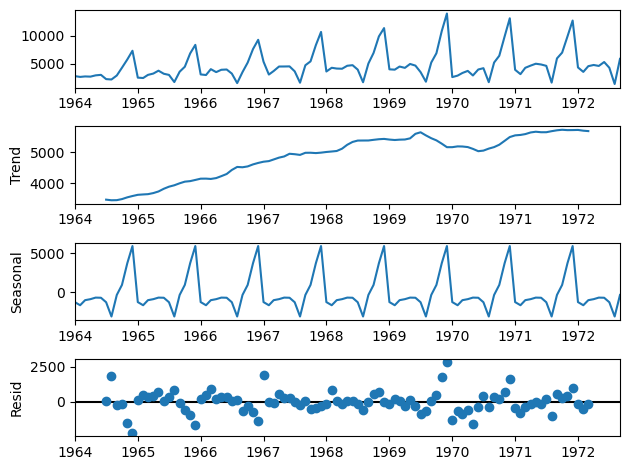

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data = seasonal_decompose(df, model="additive")
decompose_data.plot();

# Arima can only be applied to Non seasonal and Stationary data. Thus if the data is non stationary, we must make it stationary first by applying a differencing method like first order differencing or rolling mean differencing .However if the time series is seasonal, we cannot use ARIMA , we must use SARIMAX

# Adfuller Test



In [101]:
# INORDER TO TEST IF THE DATA IS STATIONARY OR NOT, WE APPLY ADFULLER TEST -A HYPOTHESIS TEST WHERE: 

#Ho: It is non stationary
#H1: It is stationary

# ON applying adfuller test on our data we get a tuple of 5 values where are second value is the p value is of major importance to us
# IF p<0.05 -> reject null hypothesis and accept alternate hypothesis.In other words if p > 0.05 ,timeseries data is not stationary
# and we must apply differencing methods to make it stationary 


In [102]:
#TESTING FOR STATIONARITY

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df.Sales)

In [103]:
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.8335930563276217
2. P-Value :  0.3639157716602457
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 93
5. Critical Values :
	 1% :  -3.502704609582561
	 5% :  -2.8931578098779522
	 10% :  -2.583636712914788


In [104]:
# P value is greater than 0.05 and hence we accept the null hypothesis that our time series data is non stationary


# Lets perform arima on our seasonal data for demonstation purposes and see why we cant use arima on seasonal data.



In [105]:
# APPLYING DIFFERENCEING TO CONVERT NON STATIONARY TIME SERIES TO STATIONARY.

# ACF AND PACF CHARTS

# PACF ie partial auto corelation function is used to find the most significant previous time stamp values that impact the current value  for our AR model(ie order of the AR- autoregressive model =p) for example if the sales of today depends on yesterday and daybeforeyesterday then p=2.

# NOTE:  PACF only describes the direct relationship between an observation and its lag .

# AR model simply aplies regression on time series data for forecasting

# ACF ie  auto corelation function is used to find the most significant previous time stamp values that impact the current value  for our MA model(ie order of the MA- moving average model model =p) for example if the sales of today depends on yesterday and daybeforeyesterday then q=2.

# NOTE: ACF includes direct and indirect dependence information

# MA or moving average model uses moving average for forecasting


# The points above the threshold line are considered significant 

# also note the d is the order of differencing appled 




In [106]:
df['Sales'].shift(12).head(20)

df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)

In [107]:
#df['First Difference']=df['Sales']-df['Sales'].shift(1)

In [108]:
df_test2 = adfuller(df['Seasonal First Difference'].dropna())

df_test2


(-7.626619157213163,
 2.060579696813685e-11,
 0,
 92,
 {'1%': -3.503514579651927,
  '5%': -2.893507960466837,
  '10%': -2.583823615311909},
 1294.7753384560438)

C:\Users\seanr\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


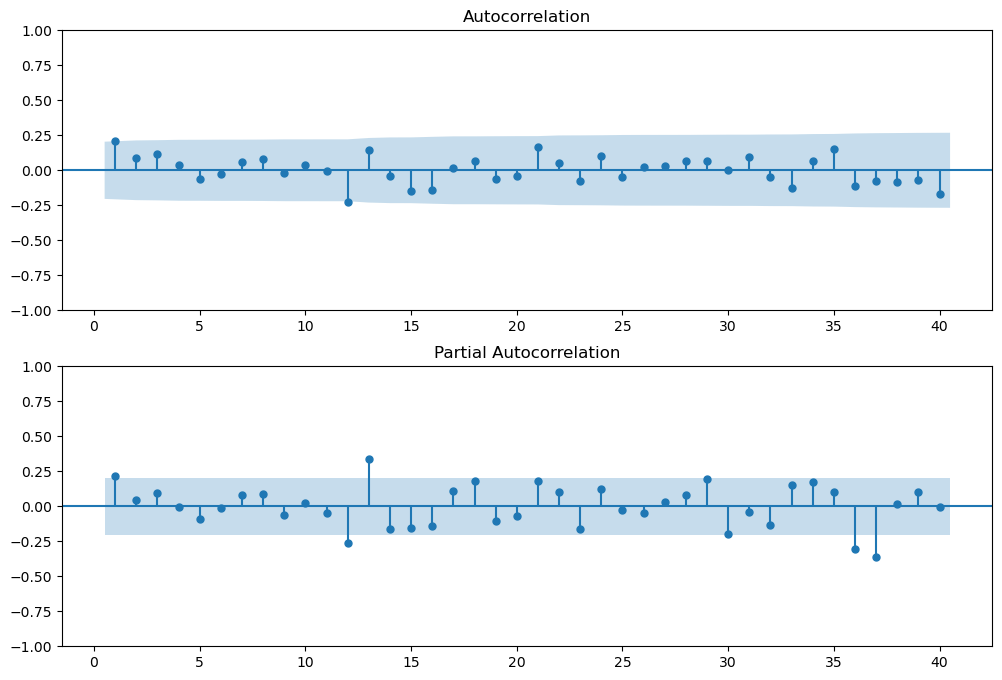

In [109]:
#FIRST LETS PLOT THE ACF AND PACF PLOT AND GET OUR p AND q VALUES ,IE. THE ORDERS TO PUT IN AS PARAMETERS


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[13:],zero=False,lags=40,ax=ax1)     
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[13:],zero=False,lags=40,ax=ax2)

# ARIMA MODEL

C:\Users\seanr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\seanr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\seanr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Month'>

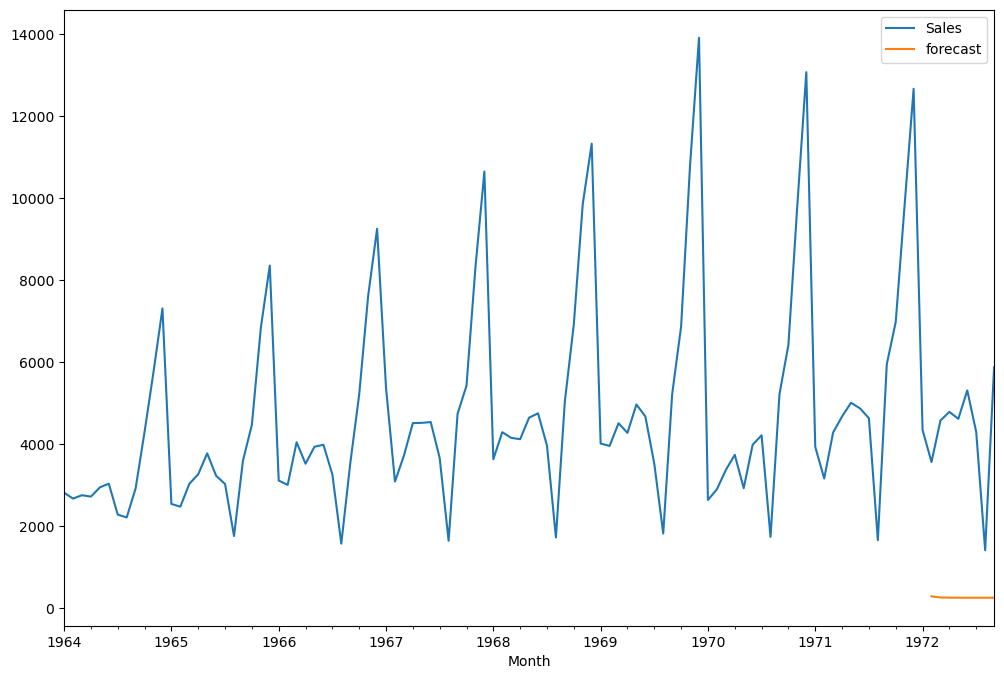

In [110]:


from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(df['Seasonal First Difference'].dropna(),order=(1,1,1))

model_fit=model.fit()

df['forecast']=model_fit.predict(start=85,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [111]:
# THUS THE PREDICTIONS ARE EXTREAMELY POOR WHEN WE APPLY ARIMA

# SARIMAX 


# TO SELECT OUR BEST PDQ VALUES, WE CAN RUN " AUTO ARIMA " 

In [112]:
# TO SELECT OUR BEST PDQ VALUES, WE CAN RUN AUTO ARIMA 


#AUTO ARIMA


import pmdarima as pm

# Create auto_arima model
model1 = pm.auto_arima(df.Sales, #time series
                      seasonal=True, # is the time series seasonal
                      m=12, # the seasonal period - one week?
                      d=1, # non-seasonal difference order
                      D=1, # seasonal difference order
                 	  max_p=6, # max value of p to test 
                      max_q=6, # max value of p to test
                      max_P=6, # max value of P to test 
                      max_Q=6, # max value of Q to test 
                      information_criterion='aic', # used to select best mode
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True) 



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1524.662, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1507.071, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1490.517, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1491.853, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1491.669, Time=0.22 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1491.700, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1490.003, Time=0.13 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1491.649, Time=0.34 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1516.612, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1485.190, Time=0.24 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1488.819, Time=0.12 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1486.738, Time=0.52 sec
 ARIMA(1,1,1)(1,1,1)[12]     

In [24]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,0,12))
models_fit=model.fit()

C:\Users\seanr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\seanr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Month'>

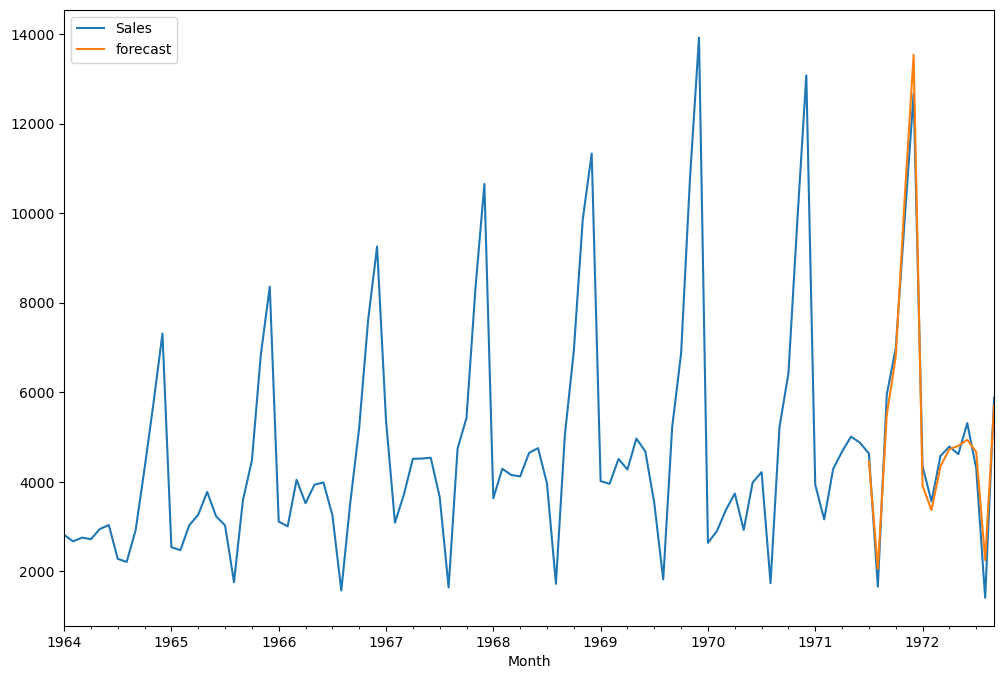

In [25]:
df['forecast']=models_fit.predict(start=90,end=104,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [26]:
# AS WE CAN SEE SARIMAX GIVES US A GOOD PREDICTION FOR OUR SEASONAL TIME SERIES DATA.

In [27]:
df.tail(15)

,Sales,Seasonal First Difference,forecast
Month,,,
1971-07-01,4633.0,416.0,4455.481044
1971-08-01,1659.0,-79.0,2059.660797
1971-09-01,5951.0,730.0,5497.967469
1971-10-01,6981.0,557.0,6795.281397
1971-11-01,9851.0,9.0,10327.836140
1971-12-01,12670.0,-406.0,13533.772071
1972-01-01,4348.0,414.0,3906.419374
1972-02-01,3564.0,402.0,3368.905086
1972-03-01,4577.0,291.0,4344.493635


In [28]:
df_temp=df.iloc[:,:]

In [29]:
df_temp = df_temp.dropna(axis=0, subset=['forecast'])

# MEAN ABSOLUTE ERROR PERFORMANCE METRIX

In [30]:
from sklearn.metrics import mean_absolute_error


score=mean_absolute_error(df_temp["Sales"],df_temp["forecast"])

print("Mean Absolute Error:",score)

Mean Absolute Error: 361.9120764178008
